# Data Science Coding Challenge for Wemanity by Ani Khachatryan

## Setup

In [78]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
# from scipy.io import arff
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# check Python version
print(f'current Python version: {sys.version}')
print(f'working directory: {os.getcwd()}')

current Python version: 3.10.9 (main, Dec 15 2022, 10:44:50) [Clang 14.0.0 (clang-1400.0.29.202)]
working directory: /Users/anikhachatryan/Documents/Projects/Wemanity/code


In [3]:
# 
output_data_dir = 'ckd/ckd/files/data/'
output_model_dir = 'ckd/ckd/files/models/'

## Data

**Note**: The data could not be loaded through scipy.io.arff.loadarff because it contains errors as discussed in <a href="https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io">this</a> StackOverflow question. In order to load it with scipy, it is necessary to manually clean the data, so I will use the code provided in one of the answers to load the data instead. 

### Load

In [4]:
# load the data to a pandas DataFrame
path_to_data = '../data/chronic_kidney_disease_full.arff'

data = []
with open(path_to_data, "r") as f:
    for i, line in enumerate(f):
        line = line.replace('\n', '')
        # I added the next three lines - remove extra '\t's, spaces, and double commas
        line = line.replace('\t', '')
        line = line.replace(' ', '')
        line = line.replace(',,', ',')
        #
        data.append(line.split(','))


names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class', 'no_name']

df = pd.DataFrame(data[145:], columns=names)
print(f'df shape: {df.shape}')

df shape: (402, 26)


### Examine

In [5]:
# examine the head of the df
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,no_name
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,7800,5.2,yes,yes,no,good,no,no,ckd,None
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,6000,?,no,no,no,good,no,no,ckd,None
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,7500,?,no,yes,no,poor,no,yes,ckd,None
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,6700,3.9,yes,no,no,poor,yes,yes,ckd,None
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,7300,4.6,no,no,no,good,no,no,ckd,None


### Clean

As mentioned in _chronic_kidney_disease.info.txt_, the data should have 400 instances and 25 attributes (we have 402 instances and 26 attributes after reading the data). 

The last two rows of the data contain no information and can be dropped. The _'no_name'_ column can also be dropped as it is a result of extra commas in the _.arff_ file.

In [6]:
# the last two rows of the data
df.iloc[400:, :]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,no_name
400,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
401,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [7]:
# drop the last two rows
df.drop([400, 401], inplace=True)

# drop the 'no_name' column
df.drop(columns='no_name', inplace=True)

print(f'df shape: {df.shape}')

df shape: (400, 25)


_chronic_kidney_disease.info.txt_ also mentions that missing values are denoted by _'?'_, so I will replace them with _NaNs_ to make it easier to deal with them later.

In [8]:
# replace '?' with NaN
df.replace('?', np.nan, inplace=True)

### Check dtypes

In [9]:
df.dtypes

age      object
bp       object
sg       object
al       object
su       object
rbc      object
pc       object
pcc      object
ba       object
bgr      object
bu       object
sc       object
sod      object
pot      object
hemo     object
pcv      object
wbcc     object
rbcc     object
htn      object
dm       object
cad      object
appet    object
pe       object
ane      object
class    object
dtype: object

It might helpful to separate numerical and categorical columns to make imputation easier.

In [10]:
# numerical columns
colnames_num = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', ]

# categorical columns
# no need to include 'class' since it's the target variable
colnames_cat = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [11]:
# convert numerical columns to numeric
df[colnames_num] = df[colnames_num].apply(pd.to_numeric, errors='coerce', axis=1)

In [12]:
# make sure dtypes are correct
df.dtypes

age      float64
bp       float64
sg        object
al        object
su        object
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

#### Save the clean version of the data to a csv file

In [13]:
# raw (unprocessed) data, but without issues
df.to_csv(os.path.join(output_data_dir, 'ckd_raw.csv'))

### Missing values

In [14]:
# number of missing values for each column
df.isna().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

Oops! Seems like we have many missing values. Since our dataset size is small as it is, removing rows with any missing values will significantly decrease our dataset size. Instead, we can impute the missing values. Categorical columns are usually imputed with the mode value, while numerical columns are usually imputed with the mean/median.

**Note**: We are making the assumption that the values are missing at random. More informaton about the dataset and the data collection process will allow to make more informed decisions on how to handle missing data.

Before we can use our data to impute missing values, it is necessary to split the data between train and test sets and set the test set aside to prevent _data leakage_.

#### Train test split

In [15]:
# separate the predictor variable
X = df.drop(columns='class')
y = df['class']

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (400, 24)
y shape: (400,)


In [16]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (300, 24)
y_train shape: (300,)
X_test shape: (100, 24)
y_test shape: (100,)


#### Save raw train and test data

In [17]:
# save raw train and test data
X_train.to_csv(os.path.join(output_data_dir, 'X_train_raw.csv'))
y_train.to_csv(os.path.join(output_data_dir, 'y_train.csv'))

X_test.to_csv(os.path.join(output_data_dir, 'X_test_raw.csv'))
y_test.to_csv(os.path.join(output_data_dir, 'y_test.csv'))

#### Impute missing values based on train data

I will perform median imputation for numerical features and mode imputation for categorical ones.

Median imputation is a common technique for handling missing values, where the missing values are replaced by the median of the non-missing values in the same column. Median imputation is often preferred over mean imputation because the median is a more robust statistic and is less sensitive to outliers.

Mode imputation is a method for handling missing values in categorical data, where the missing values are replaced by the most frequent (mode) value in the same column. Mode imputation is simple to implement and is often used when dealing with categorical data that has a large number of missing values.

In [18]:
missing_value_imputer = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy='median'), colnames_num),
        ("cat", SimpleImputer(strategy='most_frequent'), colnames_cat),
    ]
)

missing_value_imputer.fit(X_train)

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot',
                                  'hemo', 'pcv', 'wbcc', 'rbcc']),
                                ('cat', SimpleImputer(strategy='most_frequent'),
                                 ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
                                  'htn', 'dm', 'cad', 'appet', 'pe', 'ane'])])

#### Save missing_value_imputer

In [19]:
# save missing value imputer
filename = os.path.join(output_model_dir, 'mv_imputer.pkl')
pickle.dump(missing_value_imputer, open(filename, 'wb'))

#### Impute missing values on train and test data

In [20]:
# ColumnTransformer changes the ordering of the columns, 
# so this is necessary to map the resulting data columns to their names
colnames_new = [colname[5:] for colname in missing_value_imputer.get_feature_names_out()]

In [21]:
# fill in missing values for train and test
X_train = pd.DataFrame(missing_value_imputer.transform(X_train), index=X_train.index, columns=colnames_new)
X_test = pd.DataFrame(missing_value_imputer.transform(X_test), index=X_test.index, columns=colnames_new)

In [22]:
# convert numerical columns to numeric
X_train[colnames_num] = X_train[colnames_num].apply(pd.to_numeric, errors='coerce', axis=1)
X_test[colnames_num] = X_test[colnames_num].apply(pd.to_numeric, errors='coerce', axis=1)

In [23]:
# check missing values in train data
X_train.isna().sum()

age      0
bp       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64

In [24]:
# check missing values in test data
X_test.isna().sum()

age      0
bp       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64

Yay! We have no more missing values in the data.

**Note**: I did not spend a lot of time on handling missing values, but it's a crucial step of the analysis. When dealing with missing values in a real-life project, it's important to take a rigorous approach to ensure that the results are accurate and reliable. Here's a step-by-step guide on how I would go about doing this:

1. **Identify the missing values**: The first step is to identify the missing values in the dataset and understand the pattern of missingness. This can be done by creating a missing value matrix or using visualization techniques such as a heatmap or barplot.

2. **Determine the cause of missing values**: The next step is to determine the cause of the missing values. Missing values can be missing at random or not missing at random. Understanding the cause of missing values is important because it affects the choice of imputation method.

3. **Decide on the imputation method**: Based on the cause of missing values and the specific problem, it's necessary to decide on the best imputation method. This can be done by evaluating different imputation methods such as mean imputation, median imputation, mode imputation, prediction-based imputation, or multiple imputation.

4. **Implement the imputation method**: Once the imputation method has been chosen, it's necessary to implement it in the dataset. This can be done using the appropriate libraries and functions in the programming language being used.

5. **Validate the imputation method**: After implementing the imputation method, it's important to validate its accuracy by comparing the results with the original data. This can be done by using techniques such as residual plots, comparing the distribution of the data before and after imputation, or using cross-validation techniques.

6. **Refine the imputation method**: If the results of the imputation method are not satisfactory, it's necessary to refine the imputation method by repeating steps 3 to 5 until the results are acceptable.

7. **Document the process**: Finally, it's important to document the entire process, including the choices made and the results obtained. This will make it easier to reproduce the results and improve the transparency of the analysis.

In conclusion, handling missing values in a real-life project requires careful consideration, experimentation, and a rigorous approach. By following these steps, it's possible to ensure that the results are accurate and reliable, and that the analysis is transparent and repeatable.

### EDA

We will only use the train data for EDA as we don't want to take a peek inside the test set to avoid any _data leakage_.

#### Target variable

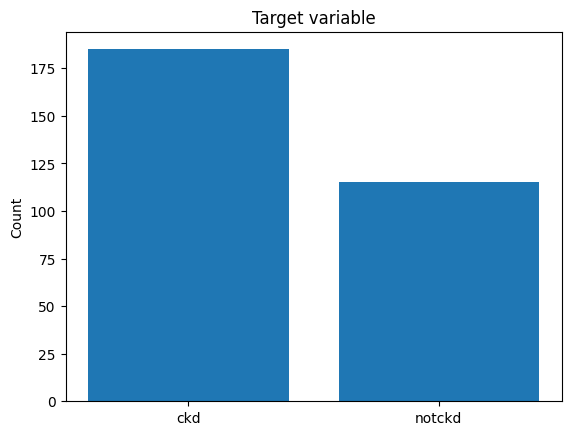

In [25]:
_ = plt.bar(y_train.value_counts().index, y_train.value_counts())
_ = plt.ylabel('Count')
_ = plt.title('Target variable')

We can see that there is class imbalance in this particular dataset.Class imbalance refers to a situation in machine learning where the number of instances of one class is significantly different from the number of instances of other classes in a dataset. To deal with class imbalance, one can follow these techniques:

- **Resampling**: This involves either oversampling the minority class or undersampling the majority class to balance the class distribution.

- **Synthetic Data Generation**: Using techniques such as Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples of the minority class.

- **Cost-sensitive Learning**: Assigning different misclassification costs to the classes in a learning algorithm to give more importance to the minority class.

- **Ensemble Methods**: Using ensemble methods such as bagging and boosting to mitigate the effects of class imbalance.

- **Model Selection**: Choosing a learning algorithm that is less sensitive to class imbalance, such as decision trees, random forests, and support vector machines.

It's important to keep in mind that there is no single solution for class imbalance and the best approach often depends on the specific problem and dataset.

#### Numerical features

In [26]:
# helper function for visually analyzing numerical variables
def eda_plots_numerical(X, y, col, bins=15):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(col)
    
    # histogram
    axs[0].hist(X[col])
    axs[0].set_ylabel('Count')

    # histogram by class
    axs[1].hist(X[y == 'ckd'][col], bins=10, alpha=.5, label='ckd')
    axs[1].hist(X[y == 'notckd'][col], bins=10, alpha=.5, label='notckd')
    axs[1].legend()
    axs[1].set_ylabel('Count')

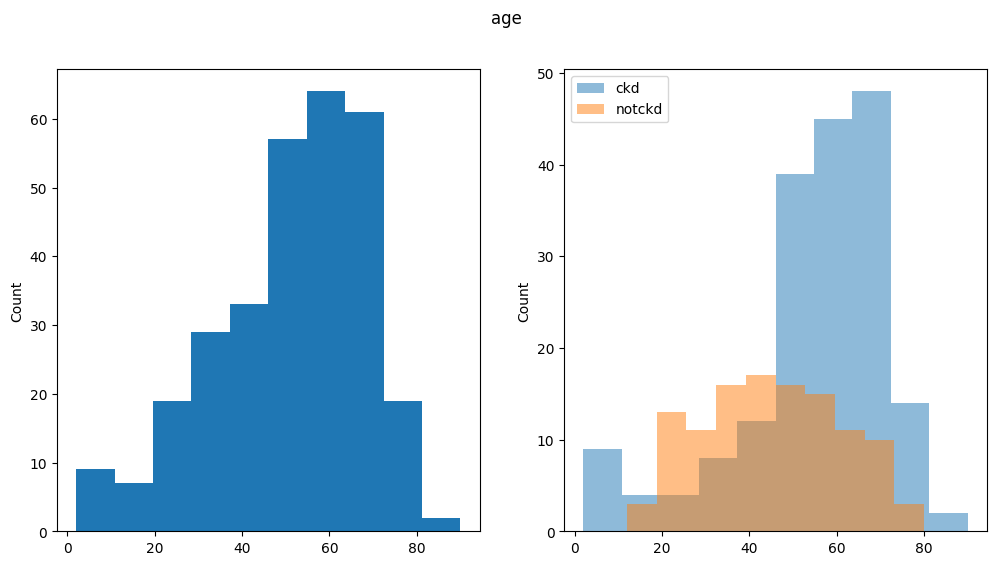

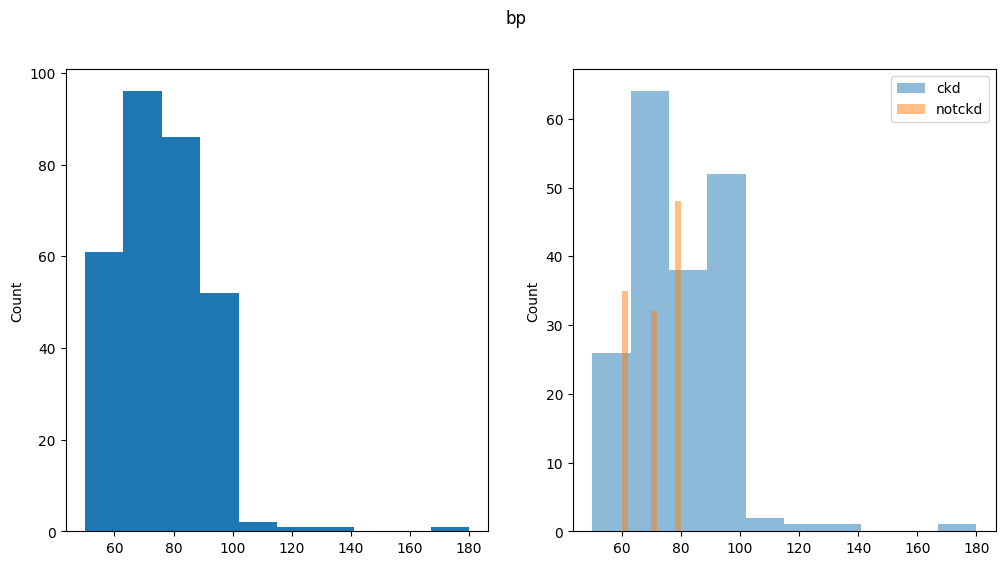

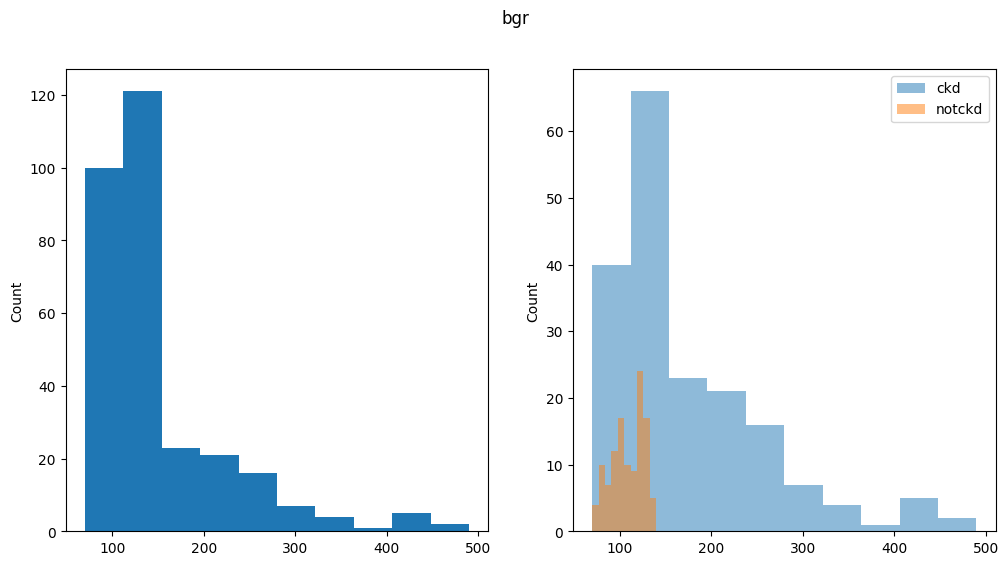

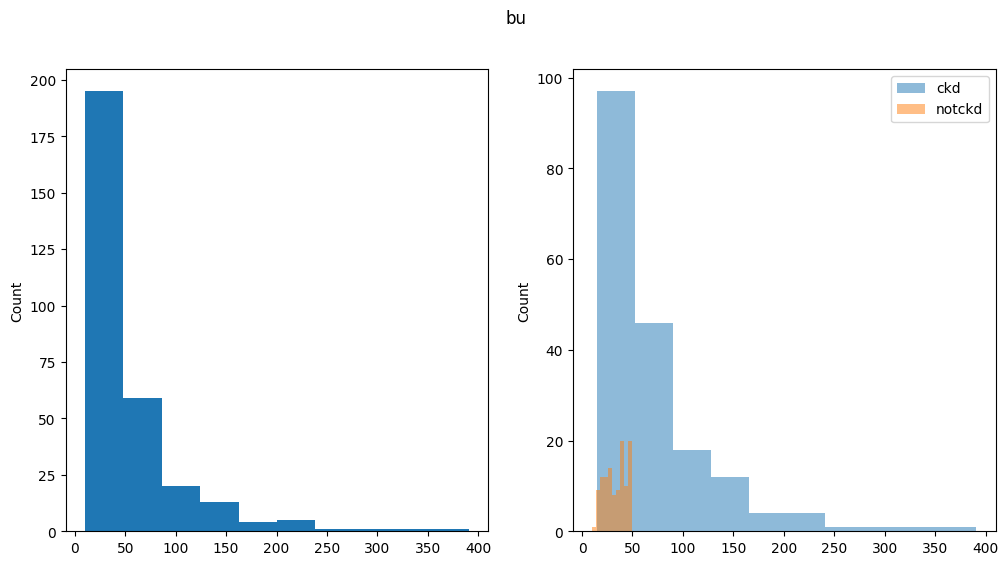

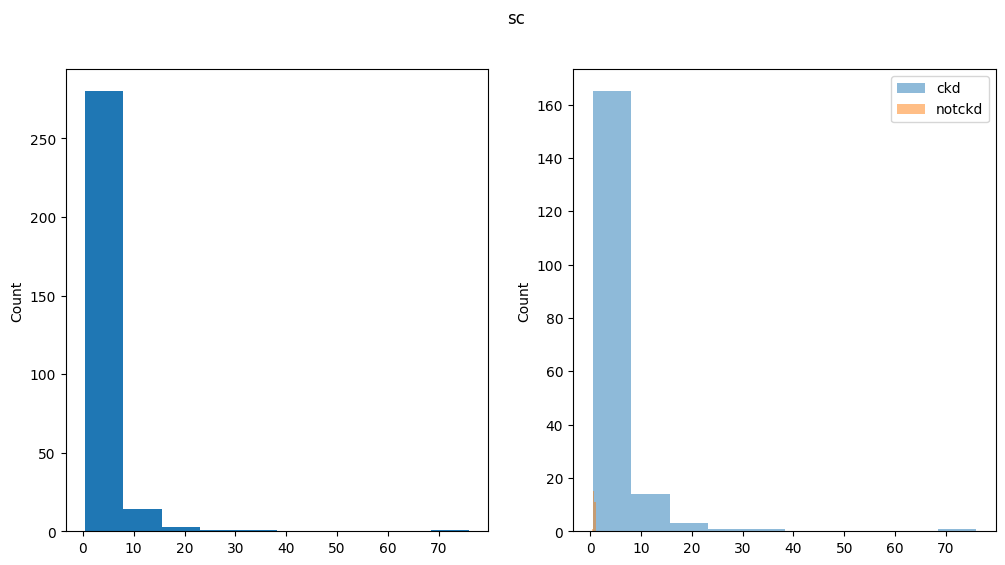

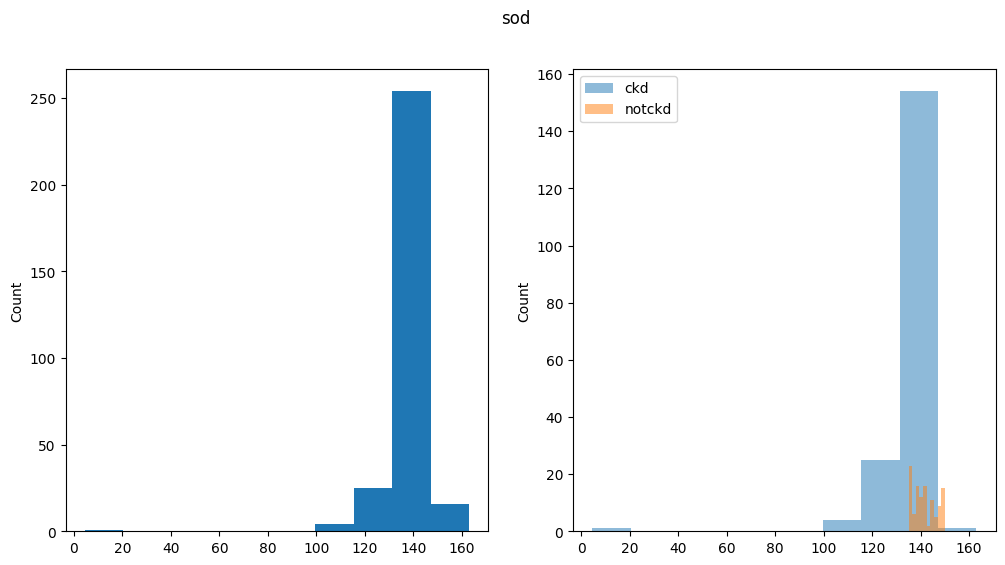

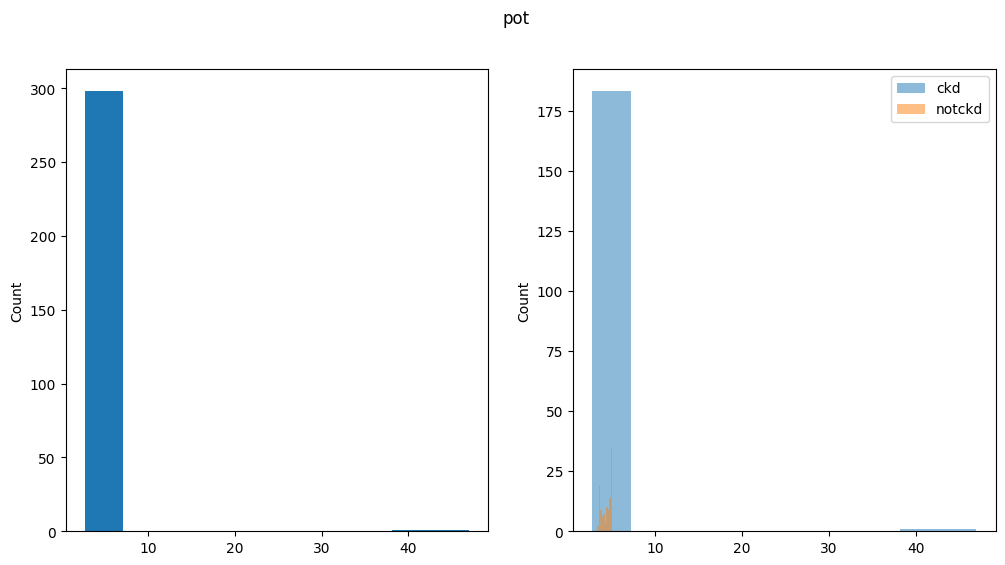

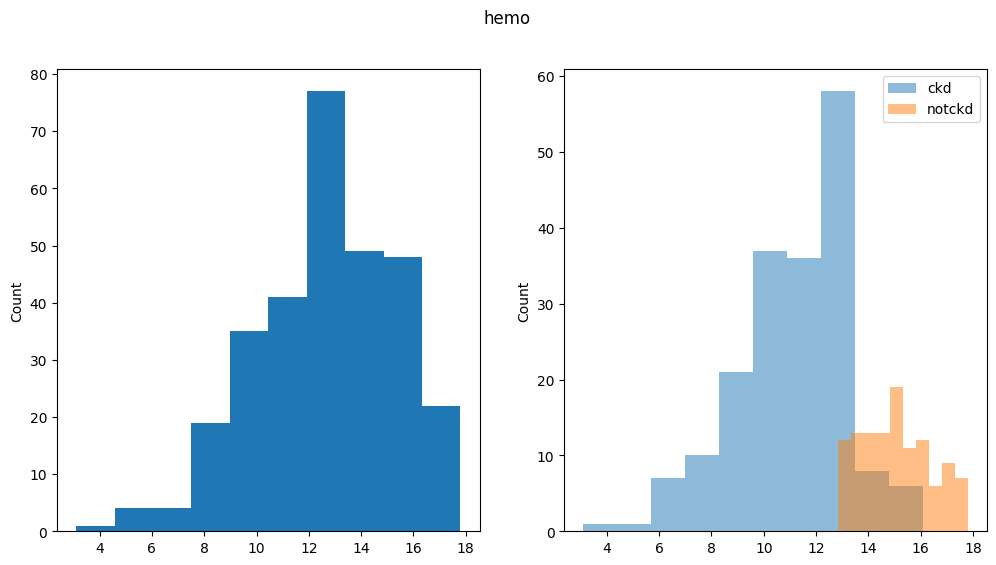

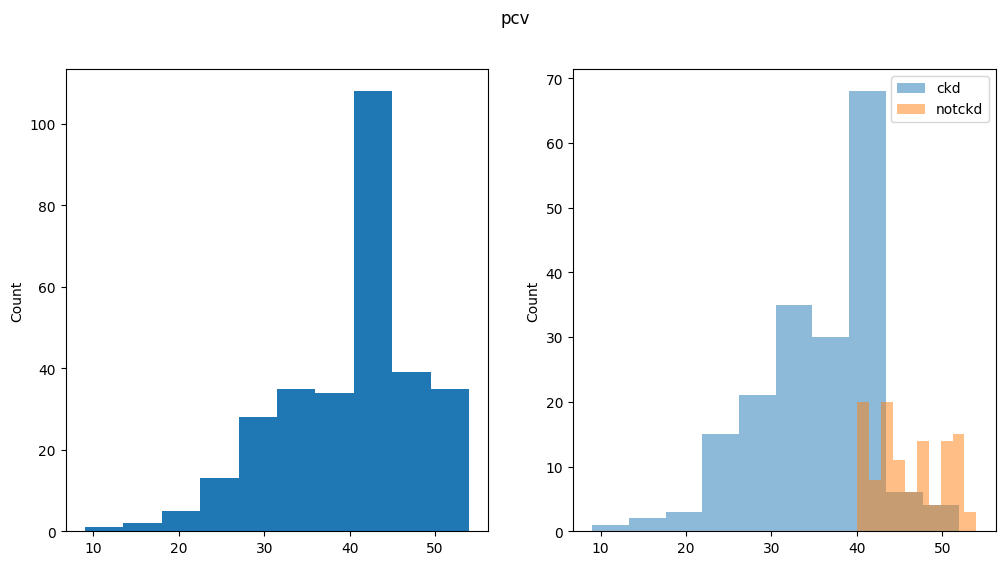

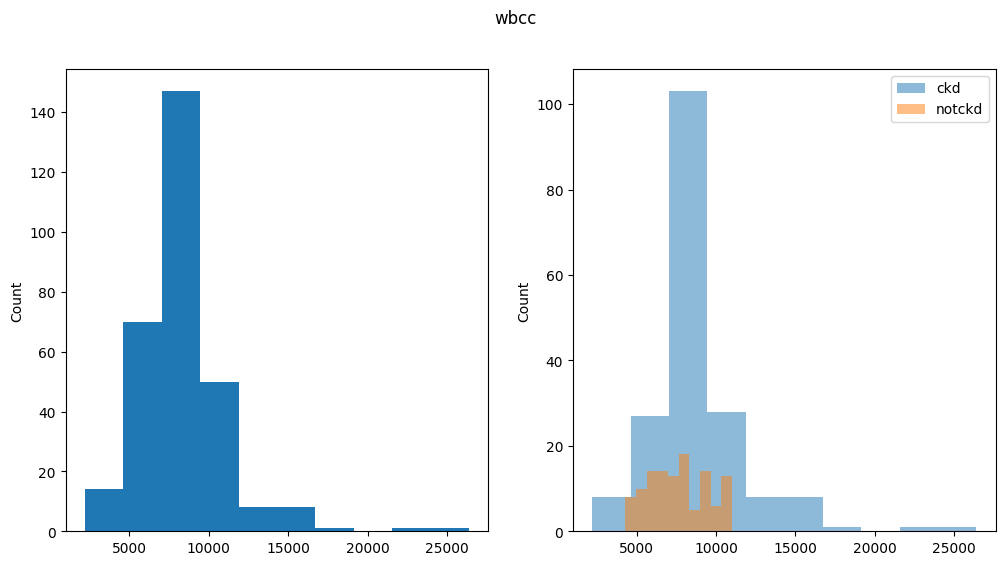

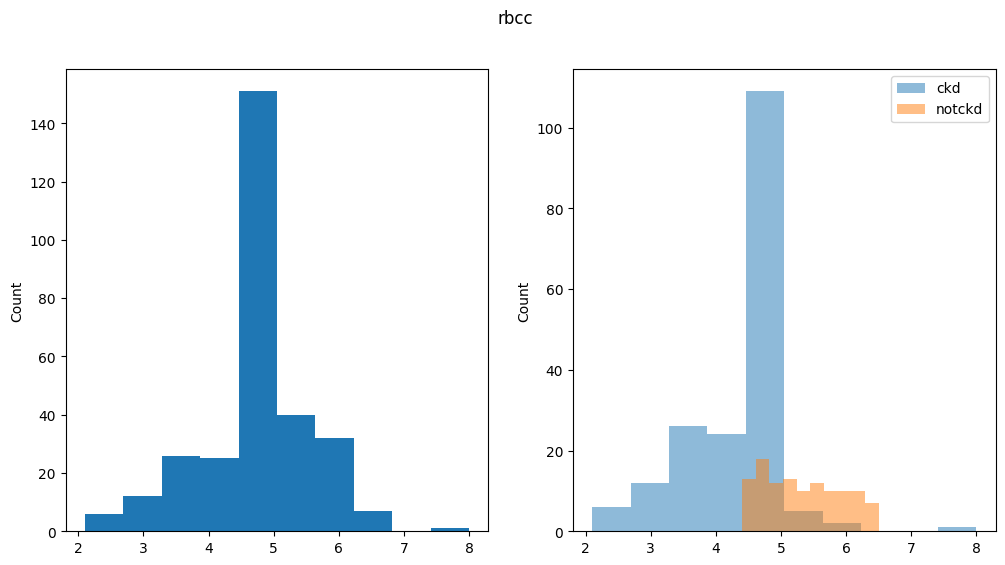

In [27]:
for col in colnames_num:
    eda_plots_numerical(X_train, y_train, col)

We can already see from the histogram plots that some variables have different distributions for the _'ckd'_ and _'notckd'_ classes, which will in turn help classify the data points into the respective categories. Some of the obviously helpful variables are _'hemo' (hemoglobin)_,  _'pcv' (packed cell volume)_, and _'rbcc' (red blood cell count)_.

#### Categorical features

In [28]:
# helper function for visually analyzing numerical variables
def eda_plots_categorical(X, y, col):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(col)
    
    # barplot
    X[col].value_counts().plot(kind='bar', rot=0, ax=axs[0])
    axs[0].set_ylabel('Count')

    # barplot by class
    pd.crosstab(X[col], y).plot(kind='bar', rot=0, ax=axs[1])
    axs[1].set_ylabel('Count')
    axs[1].set_ylabel('Count')

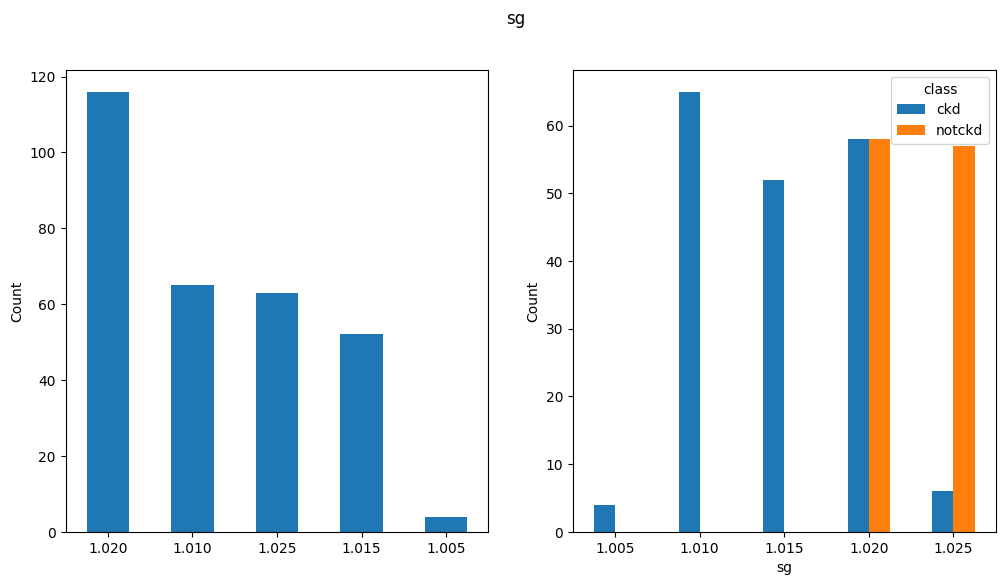

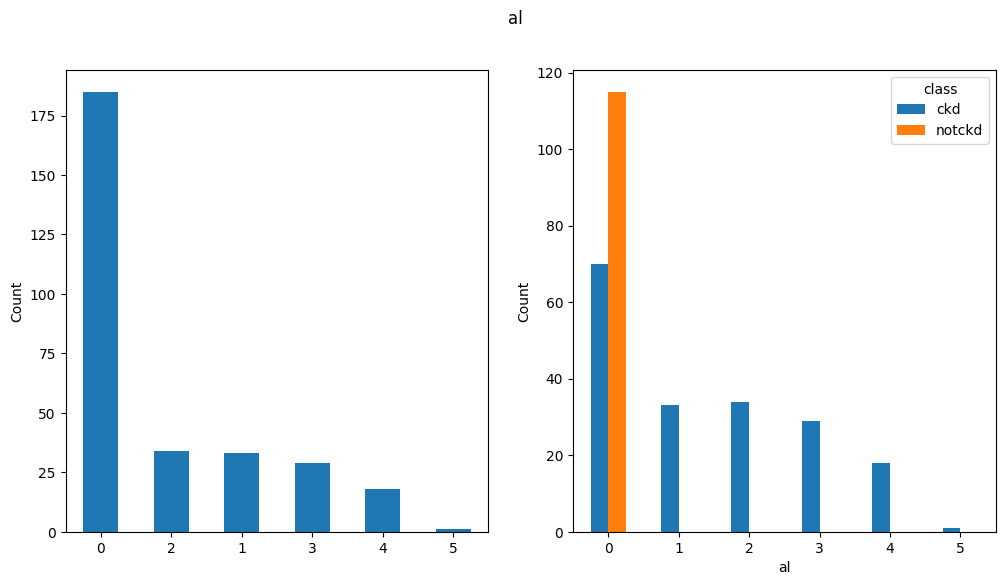

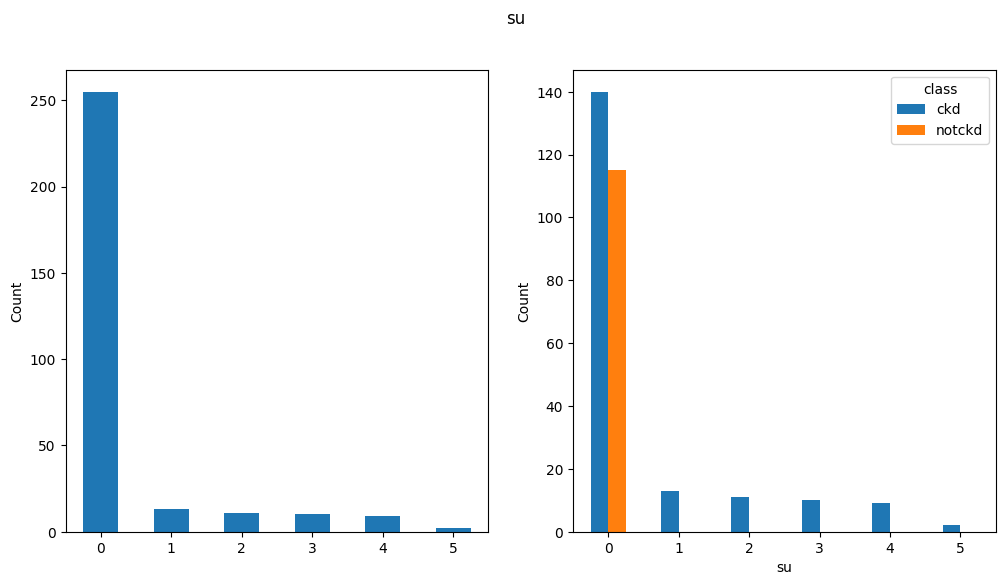

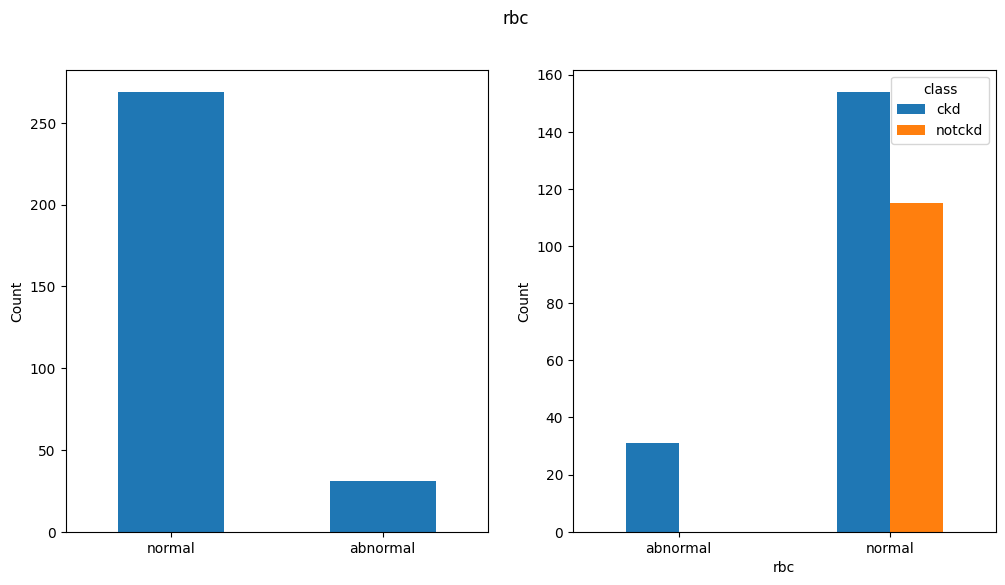

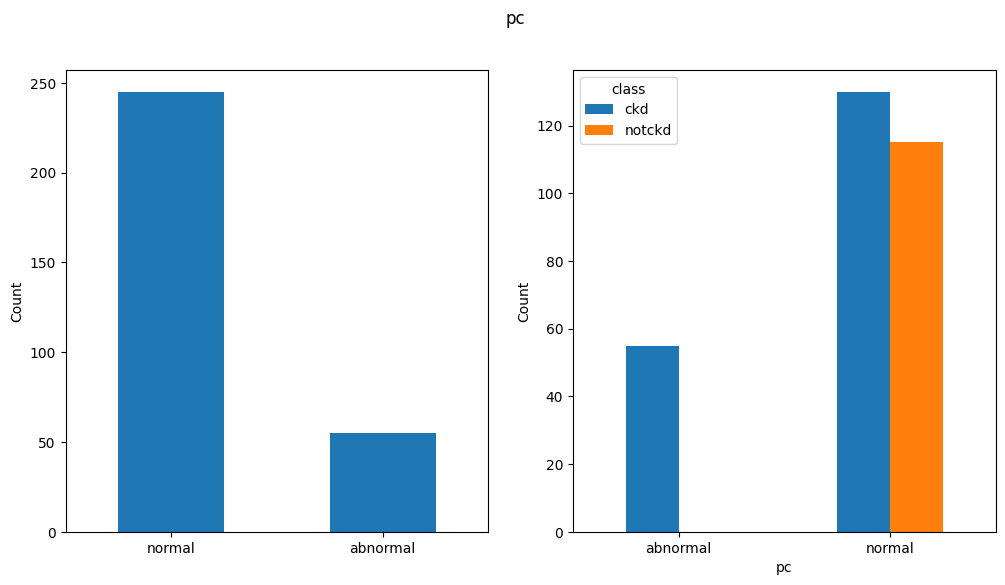

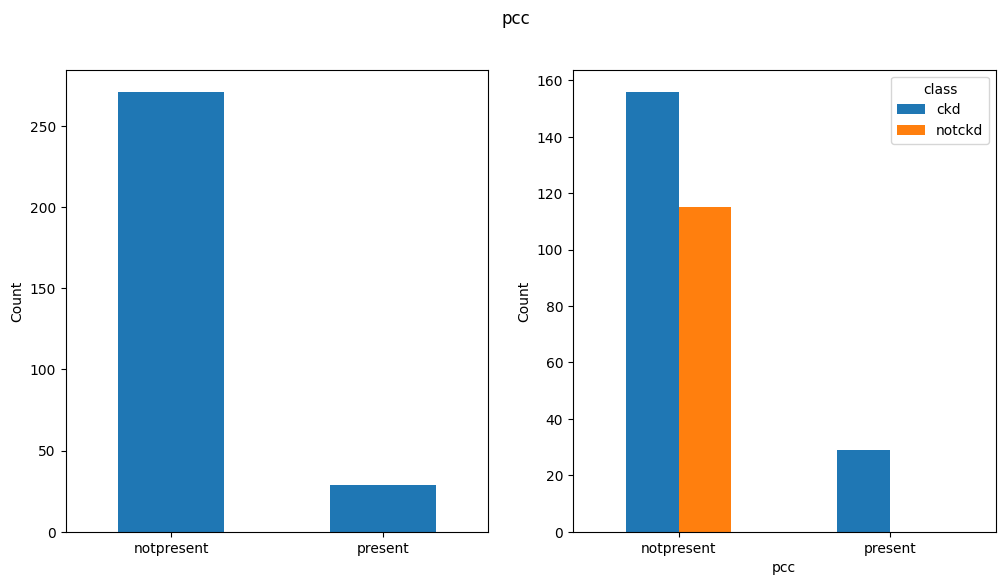

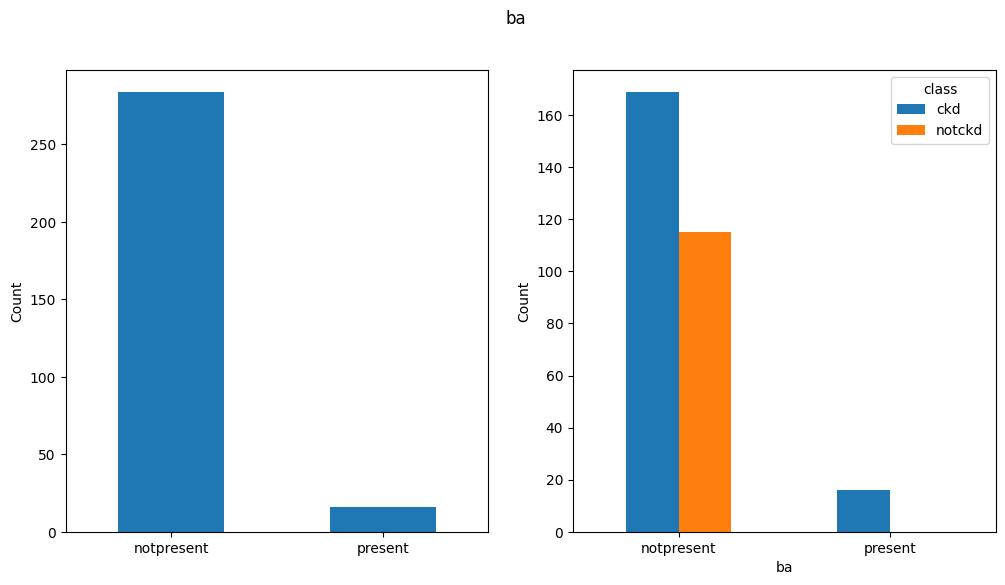

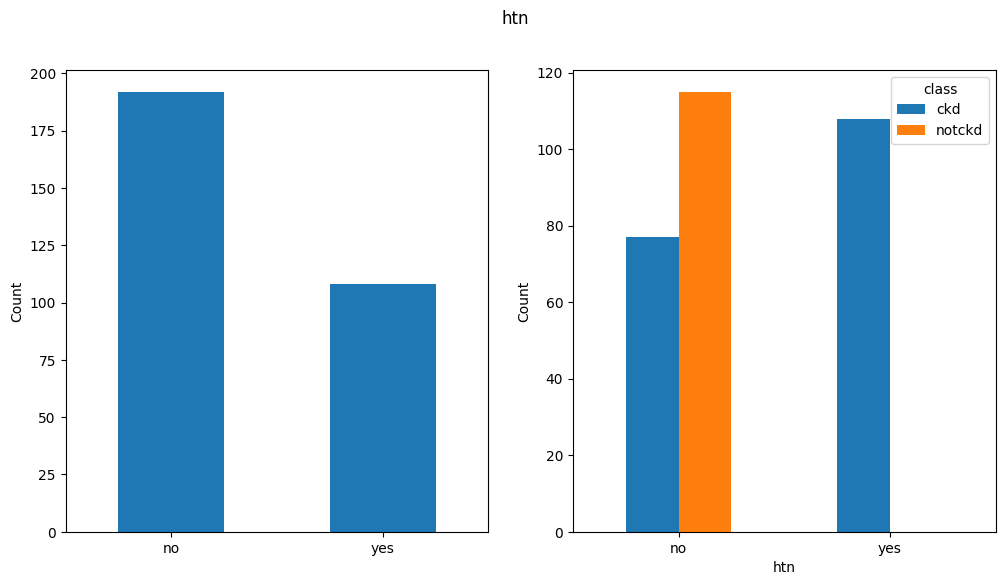

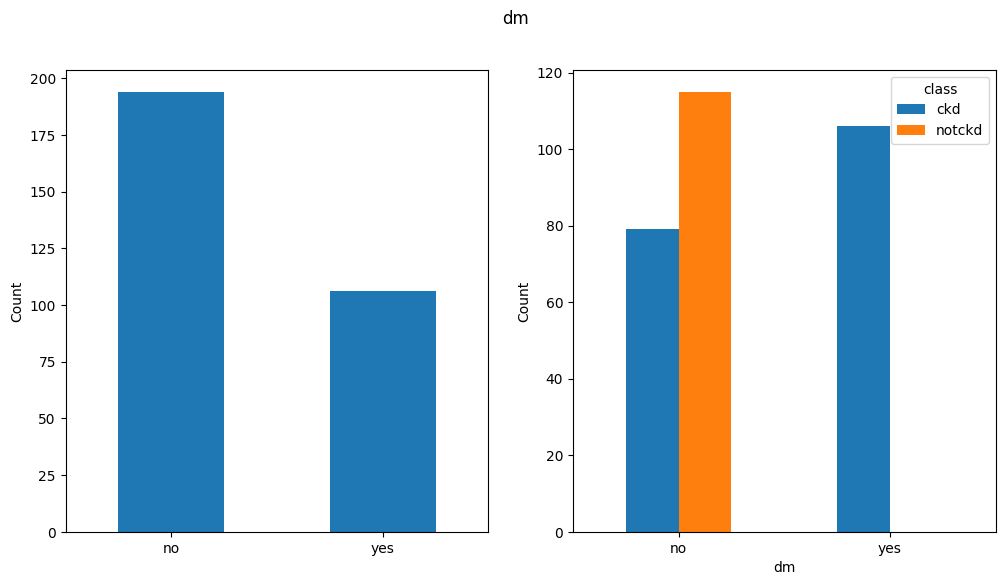

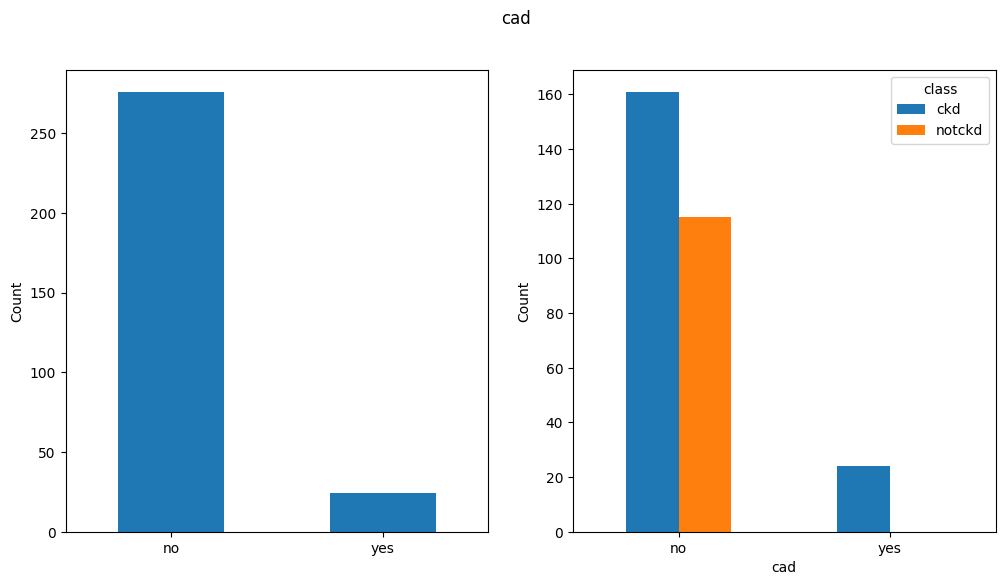

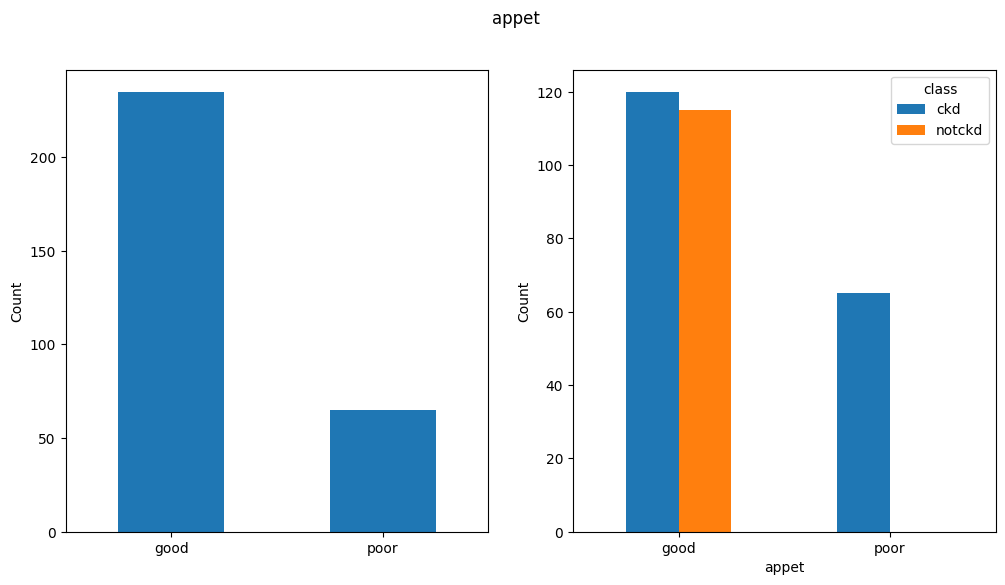

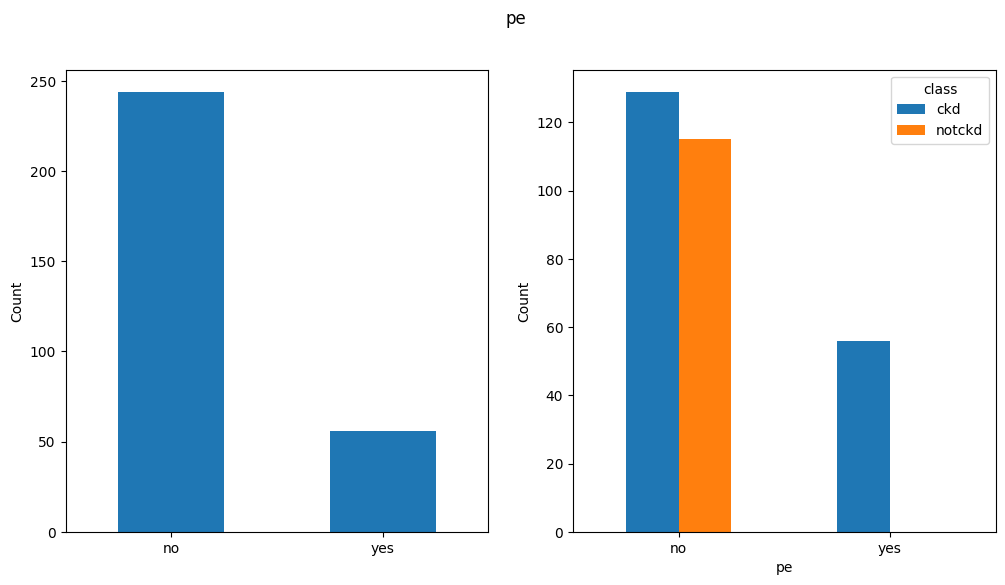

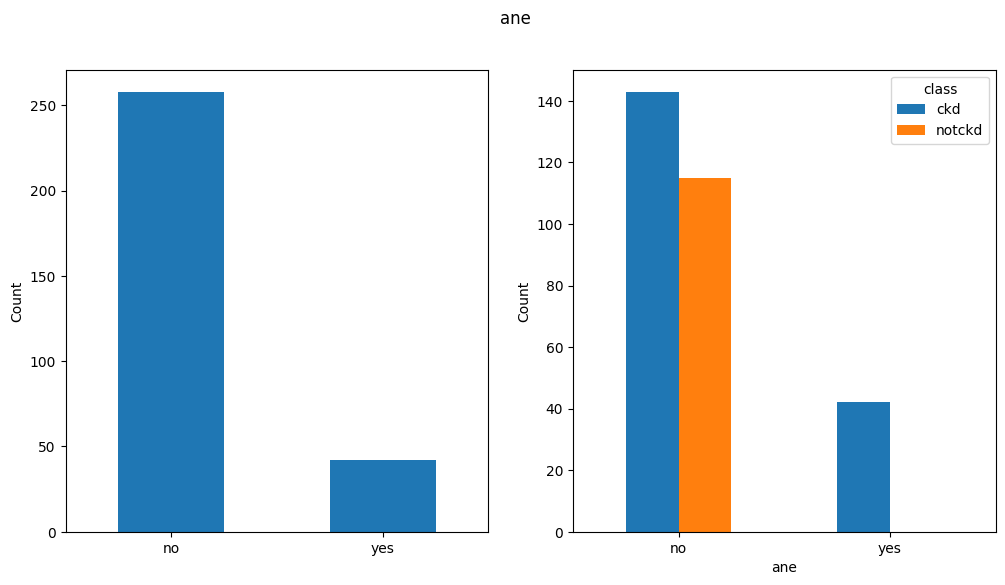

In [29]:
for col in colnames_cat:
    eda_plots_categorical(X_train, y_train, col)

We can see from the bar plots that all the categorical features are in some way associated with target variable. Usually, some categories (such as poor appetite) do not contain any _'notckd'_ values. The reason for this might be the small dataset size. In reality, it is possible for a person who does not have CKD to have poor appetite.

#### Outliers

**Note**: EDA showed that some numerical features seem to contain outliers or extreme values. In this particular case I will not remove any outlier values because in medical data, outliers may represent real-life phenomena, such as unusual medical conditions, rather than measurement errors or other types of noise. Therefore, it is important to consult medical professionals or subject matter experts to determine whether outliers in the data represent real-life phenomena or not. If the outliers represent real-life phenomena, removing them could result in a loss of important information and compromise the accuracy of the results.

Handling outliers in a real-life project requires a rigorous and systematic approach to ensure that the results are accurate, reliable, and relevant to the problem being solved. This typically involves the following steps:

1. **Identifying outliers**: This involves using various statistical methods, such as box plots, Z-scores, and the interquartile range (IQR), to identify and flag extreme values in the data.

2. **Understanding the causes of outliers**: Once outliers have been identified, it's important to understand the causes of the outliers and whether they represent real-life phenomena or measurement errors. This can be done by consulting subject matter experts, reviewing the data collection process, or performing additional analysis.

3. **Deciding on a course of action**: Based on the causes of the outliers, it's important to decide on the best course of action. If the outliers represent real-life phenomena, alternative methods, such as robust statistical methods, may be used to handle them. If the outliers are due to measurement errors, they may be removed or corrected.

4. **Documenting the process**: It's important to document the process of handling outliers, including the methods used to identify and understand the causes of outliers, the decision-making process, and the results. This documentation can help ensure that the results are reproducible and provide a clear record of the steps taken to handle outliers.

In conclusion, handling outliers in a real-life project requires a systematic and rigorous approach that involves identifying outliers, understanding the causes of outliers, deciding on a course of action, and documenting the process. This can help ensure that the results are accurate, reliable, and relevant to the problem being solved.

### Encode categorical features

In [30]:
# ref https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data

train_objs_num = len(X_train)
dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(dataset, columns=colnames_cat, drop_first=True)
X_train = dataset_preprocessed[:train_objs_num]
X_test = dataset_preprocessed[train_objs_num:]

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (300, 35)
X_test shape: (100, 35)


### Feature scaling

I will scale the features using robust scaling because it is less sensitive to outliers and extreme values as compared to standardization and min-max scaling.

In [31]:
robust_scaler = RobustScaler()
# fit on train data only to prevent data leakage
robust_scaler = robust_scaler.fit(X_train[colnames_num])

# transfor both train and test data
X_train[colnames_num] = robust_scaler.fit_transform(X_train[colnames_num])
X_test[colnames_num] = robust_scaler.transform(X_test[colnames_num])

#### Save robust scaler object to file

In [32]:
# RobustScaler
filename = os.path.join(output_model_dir, 'rb_scaler.pkl')
pickle.dump(robust_scaler, open(filename, 'wb'))

#### Save scaled train and test data

In [33]:
X_train.to_csv(os.path.join(output_data_dir, 'X_train_preprocessed.csv'))
X_test.to_csv(os.path.join(output_data_dir, 'X_test_preprocessed.csv'))

## Model

### 1. Risk factors for CKD

### Logistic Regression

Logistic Regression is a commmon statistical method for classification and I usually use it as the first step/baseline in most classification problems.

In [91]:
# Logistic Regression Classifier
lr_clf = LogisticRegression()

# fit to train data
lr_clf.fit(X_train, y_train)

# predict on test data
y_pred_lr = lr_clf.predict(X_test)

# score on test data
score_lr = lr_clf.score(X_test, y_test)
print(f'Logistic Regression Classifier test accuracy: {score_lr * 100}%')

Logistic Regression Classifier test accuracy: 100.0%


In this particular case, we have 100% test accuracy, but in most cases this will not be the so. A perfect test accuracy with logistic regression can occur when the target class is separable, meaning that the two classes can be easily distinguished based on the predictor variables. In this case, the logistic regression model will be able to perfectly predict the class labels for the test data. However, since our dataset is very small, it might also be the case that the model is overfitting and might not generalize well on new, unseen data. 

In general, when assessing classifier performance, accuracy might not be the best metric, especially when there is class imbalance in the dataset. To better understand the classifier performance, we can look at the classification report and the confusion matrix.

In [92]:
# print classification report
print('Classification report (Logistic Regression Classifier)')
print(classification_report(y_test, y_pred_lr))

Classification report (Logistic Regression Classifier)
              precision    recall  f1-score   support

         ckd       1.00      1.00      1.00        65
      notckd       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



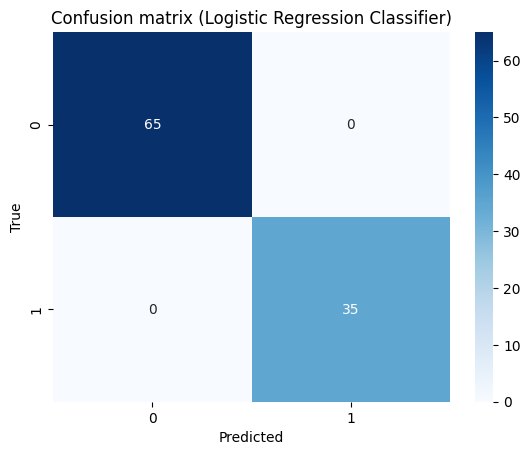

In [93]:
# get the confusion matrix
conf_mat_lr = confusion_matrix(y_test, y_pred_lr)

# plot the confusion matrix
s = sns.heatmap(conf_mat_lr, annot=True, fmt='g', cmap="Blues")
_ = s.set(xlabel='Predicted', ylabel='True', title='Confusion matrix (Logistic Regression Classifier)')

#### Save the trained model

In [43]:
# Linear Regression
filename = os.path.join(output_model_dir, 'lr_clf.pkl')
pickle.dump(lr_clf, open(filename, 'wb'))

In [ ]:
# helper function 

#### Feature importance aka potential risk factors for CKD
Logistic Regression coefficients can be used to understand which features were the most important when predicting the targed vairable (_'ckd'_ vs _'notckd'_).

**Note**: Coefficients of logistic regression are sensitive to the scaling of the predictor variables. If the predictor variables have different units or scales, the coefficients may not reflect the true importance of the features. For example, a large coefficient for a feature with a large scale may not be as important as a small coefficient for a feature with a smaller scale.

In such cases, using robust scaling on the predictor variables can be useful in mitigating the effect of outliers on the coefficients. However, the coefficients obtained from a logistic regression model with robustly scaled predictor variables may still not be the best indicators of feature importance.

This is because the objective of robust scaling is to reduce the impact of outliers on the scaling of the predictor variables, but it does not necessarily reflect the true relationship between the features and the target variable. In such cases, other methods, such as odds ratios, partial dependence plots, or feature importance measures based on permutation, may provide a better understanding of feature importance.

In conclusion, while coefficients can provide information on the relationship between features and the target variable, it may not be the best indicator of feature importance when using robust scaling, and other methods should be considered for a more comprehensive understanding of feature importance.

In [61]:
# print the top 10 features with the highest absolute coefficient values
pd.DataFrame({'abs_coef': abs(lr_clf.coef_[0]), \
              'feature_name':X_train.columns}).sort_values('abs_coef', ascending=False).head(10)

,abs_coef,feature_name
7,1.815647,hemo
14,1.629642,sg_1.025
4,1.580980,sc
11,1.462128,sg_1.010
30,1.163363,dm_yes
8,1.139026,pcv
32,1.004753,appet_poor
2,0.960147,bgr
12,0.951298,sg_1.015
29,0.942163,htn_yes


Some of the most influential features on target value prediction were _'hemo' (hemoglobin)_, _'sg' (specific gravity)_, _'sc' (serum creatinine)_, _'dm' (diabetes mellitus)_, _'pcv' (packed cell volume)_, _'appet' (appetite)_, _'bgr' (blood glucose random)_, and _'htn' (hypertension)_.

These are known risk factors for CKD and are commonly mentioned in research papers.

### Random Forest Classifier

Random Forest Classifier is an ensemble machine learning algorithm commonly used for classification problems. It combines multiple decision trees to make predictions and can handle both linear and non-linear relationships between the features and the target variable. 

The algorithm works by creating a large number of decision trees, each using a randomly selected subset of the features and a random subset of the training data. The predictions from each decision tree are then combined through a majority vote. 

Random Forest Classifier is a powerful and widely used algorithm due to its ability to handle non-linear relationships between features and target variable. It is also resistant to overfitting, which is a common problem in decision tree algorithms.

In [66]:
# Random Forest Classifier
rf_clf = RandomForestClassifier()

# fit to train data
rf_clf.fit(X_train, y_train)

# predict on test data
y_pred_rf = rf_clf.predict(X_test)

# score on test data
score_rf = rf_clf.score(X_test, y_test)
print(f'Random Forest Classifier test accuracy: {score_rf * 100}%')

Random Forest Classifier test accuracy: 100.0%


In [89]:
# print classification report
print('Classification report (Random Forest Classifier)')
print(classification_report(y_test, y_pred_rf))


Classification report (Random Forest Classifier)
              precision    recall  f1-score   support

         ckd       1.00      1.00      1.00        65
      notckd       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



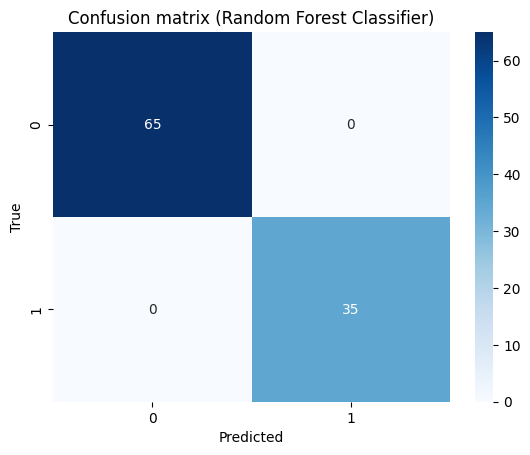

In [87]:
# get the confusion matrix
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)

# plot the confusion matrix
s = sns.heatmap(conf_mat_rf, annot=True, fmt='g', cmap="Blues")
_ = s.set(xlabel='Predicted', ylabel='True', title='Confusion matrix (Random Forest Classifier)')

#### Save the trained model

In [67]:
# Random Forest Classifier
filename = os.path.join(output_model_dir, 'rf_clf.pkl')
pickle.dump(rf_clf, open(filename, 'wb'))

#### Feature importances

Random Forest Classifier calculates feature importance by considering the decrease in impurity (i.e. increase in accuracy) resulting from the use of each feature in multiple decision trees in the forest. The feature importance is determined by aggregating the improvement in accuracy across all trees in the forest.

In [68]:
# print the top 10 features with the highest feature importances
pd.DataFrame({'feature_importance': abs(rf_clf.feature_importances_), \
              'feature_name':X_train.columns}).sort_values('feature_importance', ascending=False).head(10)

,feature_importance,feature_name
7,0.180102,hemo
4,0.152090,sc
8,0.102608,pcv
10,0.088504,rbcc
29,0.076706,htn_yes
30,0.058438,dm_yes
5,0.038563,sod
3,0.037912,bu
2,0.036711,bgr
11,0.033696,sg_1.010


Some of the most important features were _'hemo' (hemoglobin)_, _'sc' (serum creatinine)_, _'pcv' (packed cell volume)_, _'rbcc' (red blood cell count)_, _'htn' (hypertension)_, _'dm' (diabetes mellitus)_, _'sod' (sodium)_, _'bu' (blood urea)_, _'bgr' (blood glucose random)_, and _'sg' (specific gravity)_.

There is significant overlap with the risk factors identified with the Logistic Regression model. 

### 2. Potential CKD subtypes

In order to understand potential CKD subtypes we can perform clustering on our data to find groups within the _'ckd'_ data points.

In [254]:
# only select rows where class is 'ckd'
X_ckd = df[df['class'] == 'ckd']

# drop the target variable
X_ckd = X_ckd.drop(columns='class')

print(f'X_ckd shape: {X_ckd.shape}')

X_ckd shape: (250, 24)


Dimensionality reduction is often performed before clustering for several reasons:

- **Curse of dimensionality**: As the number of features (dimensions) increases, the amount of data required to achieve a certain level of accuracy also increases exponentially. This results in overfitting and a decrease in the performance of clustering algorithms.

- **Feature selection**: Dimensionality reduction can be used to identify the most important features to be used in the clustering process, reducing the number of irrelevant or redundant features.

- **Visualization**: Reducing the number of dimensions makes it easier to visualize the data and interpret the results of the clustering process.

- **Improved performance**: By reducing the number of dimensions, clustering algorithms can process the data faster and more accurately. This can be particularly important for large datasets or complex algorithms.

#### Fill in missing values

In [255]:
missing_value_imputer = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy='mean'), colnames_num),
        ("cat", SimpleImputer(strategy='most_frequent'), colnames_cat),
    ]
)

missing_value_imputer.fit(X_ckd)

# ColumnTransformer changes the ordering of the columns, 
# so this is necessary to map the resulting data columns to their names
colnames_new = [colname[5:] for colname in missing_value_imputer.get_feature_names_out()]

# fill in missing values for train and test
X_ckd = pd.DataFrame(missing_value_imputer.transform(X_ckd), index=X_ckd.index, columns=colnames_new)

#### Encode categorical columns

In [256]:
X_ckd = pd.get_dummies(X_ckd, columns=colnames_cat, drop_first=True)

# make a copy for later analysis
df_ckd = X_ckd.copy()
df_ckd[colnames_num] = df_ckd[colnames_num].apply(pd.to_numeric, errors='coerce', axis=1)

#### FAMD

[FAMD](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210) is a dimensionality reduction technique specifically designed for mixed data (both numerical and categorical variables) by finding a smaller number of underlying factors that explain the variation in the data. It can handle missing data and is useful for data preprocessing and analysis.

In [257]:
# a) Standard scale the numerical variables (= get the z-score)
std_scaler = StandardScaler()
X_ckd[colnames_num] = std_scaler.fit_transform(X_ckd[colnames_num])

In [258]:
# b) For the categorical variables:
# - Get the one-hot encoded columns
# done

# get categorical columns
cat_cols = X_ckd.select_dtypes(include='uint8').columns.to_list()

# - Divide each column by the square root of its probability sqrt(μₘ)
X_ckd[cat_cols] = X_ckd[cat_cols] / np.sqrt(X_ckd[cat_cols].mean(axis=0))

# - Center the columns
X_ckd[cat_cols] = X_ckd[cat_cols] - X_ckd[cat_cols].mean(axis=0)

In [259]:
df_ckd

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,...,rbc_normal,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.0,80.0,121.000000,36.0,1.2,133.901786,4.878443,15.400000,44.000000,7800.000000,...,1,1,0,0,1,1,0,0,0,0
1,7.0,50.0,175.419811,18.0,0.8,133.901786,4.878443,11.300000,38.000000,6000.000000,...,1,1,0,0,0,0,0,0,0,0
2,62.0,80.0,423.000000,53.0,1.8,133.901786,4.878443,9.600000,31.000000,7500.000000,...,1,1,0,0,0,1,0,1,0,1
3,48.0,70.0,117.000000,56.0,3.8,111.000000,2.500000,11.200000,32.000000,6700.000000,...,1,0,1,0,1,0,0,1,1,1
4,51.0,80.0,106.000000,26.0,1.4,133.901786,4.878443,11.600000,35.000000,7300.000000,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,48.0,100.0,103.000000,79.0,5.3,135.000000,6.300000,6.300000,19.000000,7200.000000,...,1,1,0,0,1,0,1,1,0,0
246,48.0,110.0,106.000000,215.0,15.2,120.000000,5.700000,8.600000,26.000000,5000.000000,...,0,1,1,0,1,0,1,0,0,1
247,54.0,90.0,150.000000,18.0,1.2,140.000000,4.200000,10.647549,32.939891,9069.536424,...,1,0,0,0,0,0,0,1,1,1
248,59.0,70.0,424.000000,55.0,1.7,138.000000,4.500000,12.600000,37.000000,10200.000000,...,0,0,0,0,1,1,1,0,0,0


#### PCA

In [260]:
# c) Apply a PCA algorithm over the table obtained!
pca_ckd = PCA(n_components=X_ckd.shape[1])
principalComponents_ckd = pca_ckd.fit_transform(X_ckd)

In [261]:
print(f'Explained variation per principal component:\n {pca_ckd.explained_variance_ratio_}')

Explained variation per principal component:
 [0.12861315 0.06715361 0.05860726 0.05218828 0.0494886  0.04424939
 0.04344145 0.04068877 0.03832151 0.03762475 0.0360922  0.03516589
 0.03368793 0.03214878 0.0312208  0.02840579 0.02723533 0.02436893
 0.02327023 0.02234998 0.02038714 0.01723726 0.01524876 0.01364116
 0.01247039 0.01230725 0.01048452 0.00924888 0.00854945 0.00756908
 0.00631012 0.00475399 0.0036745  0.00297383 0.00082101]


In [262]:
print(f'Comulative explained variation:\n {np.cumsum(pca_ckd.explained_variance_ratio_)}')

Comulative explained variation:
 [0.12861315 0.19576676 0.25437402 0.3065623  0.3560509  0.40030029
 0.44374174 0.48443051 0.52275203 0.56037678 0.59646898 0.63163487
 0.6653228  0.69747158 0.72869238 0.75709817 0.7843335  0.80870243
 0.83197267 0.85432265 0.8747098  0.89194706 0.90719582 0.92083698
 0.93330737 0.94561462 0.95609914 0.96534803 0.97389747 0.98146655
 0.98777667 0.99253066 0.99620516 0.99917899 1.        ]


In [263]:
# find the number of principal components necessary to explain p*100 percent of variance
p = .75
l = np.cumsum(pca_ckd.explained_variance_ratio_) >= p
ncomp = next(i for i,v in enumerate(l) if v)
print(15)

15


In [264]:
pca_ckd = PCA(n_components=ncomp)
principalComponents_ckd = pca_ckd.fit_transform(X_ckd)
print(f'principalComponents_ckd shape: {principalComponents_ckd.shape}')

principalComponents_ckd shape: (250, 15)


#### K-means using principal components

I will use the _silhouette score_ to choose the optimal number of clusters.

The silhouette score is a metric for evaluating clustering algorithms that measures the similarity of an object to its own cluster compared to other clusters. The score ranges from -1 to 1, with higher values indicating a better clustering performance. It helps to choose the optimal number of clusters.

**Note**: Since our dataset is very small, this analysis might not at all be optimal. It would be necessary to do a more rigorous analysis to find CKD subtypes using clustering.

In [265]:
scores = []
# try several values of k
for n_clusters in range(2,7):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    preds = kmeans.fit_predict(principalComponents_ckd)
    centers = kmeans.cluster_centers_

    score = silhouette_score(principalComponents_ckd, preds)
    print(f'k={n_clusters}, silhouette score: {score}')
    scores.append(score)

k=2, silhouette score: 0.16797944624751832
k=3, silhouette score: 0.1314478548320027
k=4, silhouette score: 0.08601240193468333
k=5, silhouette score: 0.1472738721997375
k=6, silhouette score: 0.10890435379970989


Cluster with KMeans again with n=2.

In [266]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
clusters = kmeans.fit_predict(principalComponents_ckd)

In [279]:
# print cluster sizes
print(f'Cluster 1 size: {sum(clusters == 0)}')
print(f'Cluster 2 size: {sum(clusters == 1)}')

Cluster 1 size: 74
Cluster 2 size: 176


Compare cluster means.

In [280]:
df_ckd_0 = df_ckd[clusters == 0]
df_ckd_1 = df_ckd[clusters == 1]

summary0 = df_ckd_0.describe().loc['mean']
summary1 = df_ckd_1.describe().loc['mean']

In [281]:
print('Cluster comparison')
print(pd.concat((summary0.rename('Cluster 1'), summary1.rename('Cluster 2')), axis=1))

Cluster comparison
               Cluster 1    Cluster 2
age            57.894126    53.131621
bp             80.535473    79.242188
bgr           173.761601   176.117013
bu            123.521622    50.890099
sc              8.765541     2.585676
sod           131.021839   135.112672
pot             5.725465     4.522309
hemo            8.653922    11.485779
pcv            27.220795    35.344511
wbcc         8799.874709  9182.916918
rbcc            3.460618     4.148999
sg_1.010        0.648649     0.443182
sg_1.015        0.216216     0.335227
sg_1.020        0.067568     0.147727
sg_1.025        0.027027     0.051136
al_1            0.081081     0.215909
al_2            0.162162     0.176136
al_3            0.270270     0.130682
al_4            0.162162     0.068182
al_5            0.013514     0.000000
su_1            0.094595     0.034091
su_2            0.094595     0.062500
su_3            0.067568     0.051136
su_4            0.040541     0.056818
su_5            0.000000     0.

It seems like there are some differences between the two clusters. Some notable ones are
- Cluster 1 seems to have _higher_ average _age_ than cluster 2
- Cluster 1 seems to have _higher_ average _blood urea_ than cluster 2
- Cluster 1 seems to have _higher_ average _serum creatinine_ than cluster 2
- Cluster 1 seems to have _lower_ average _hemoglobin_ than cluster 2
- etc

Cluster 1 seems to contain more serious cases of CKD and knowing which cluster a patient belongs to might help in providing more precise care.

# Thank you! 